In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
!pip install h5py -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 2.9 MB 6.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [7]:
import numpy as np
import h5py
import os
import random
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image

from os import path as osp
from k12libs.utils.nb_easy import K12AI_NBDATA_ROOT

# NYU Depth V2 Dataset

## Split Train & Test Data

In [30]:
data = sio.loadmat(osp.join(K12AI_NBDATA_ROOT, 'splits.mat'))
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'trainNdxs', 'testNdxs'])

In [31]:
train_idx = data['trainNdxs']
test_idx = data['testNdxs']
type(test_idx), test_idx[:5], \
len(train_idx), len(test_idx), \
train_idx[0], train_idx[0][0]

(numpy.ndarray,
 array([[ 1],
        [ 2],
        [ 9],
        [14],
        [15]], dtype=uint16),
 795,
 654,
 array([3], dtype=uint16),
 3)

In [10]:
nyu_mat = h5py.File(osp.join(K12AI_NBDATA_ROOT, 'nyu_depth_v2_labeled.mat'), 'r')

In [11]:
images = nyu_mat["images"]
depths = nyu_mat["depths"]
labels = nyu_mat["labels"]
accel =  nyu_mat['accelData']

In [12]:
len(images), len(depths), len(labels), len(accel), \
type(images), type(depths), type(labels), type(accel)

(1449,
 1449,
 1449,
 4,
 h5py._hl.dataset.Dataset,
 h5py._hl.dataset.Dataset,
 h5py._hl.dataset.Dataset,
 h5py._hl.dataset.Dataset)

In [13]:
images = np.array(images)
depths = np.array(depths)
labels = np.array(labels)

type(images), type(depths), type(labels), \
images.shape, depths.shape, labels.shape

(numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 (1449, 3, 640, 480),
 (1449, 640, 480),
 (1449, 640, 480))

In [83]:
nyu_root = osp.join(K12AI_NBDATA_ROOT, 'nyu_v2')
train_path = osp.join(nyu_root, 'train')
val_path = osp.join(nyu_root, 'val')
test_path = osp.join(nyu_root, 'test')

if not osp.isdir(train_path):
    os.makedirs(train_path) 
if not osp.isdir(val_path):
    os.makedirs(val_path) 
if not osp.isdir(test_path):
    os.makedirs(test_path) 

nyu_imgs_root = osp.join(K12AI_NBDATA_ROOT, 'nyu_v2/imgs')
train_imgs_path = osp.join(nyu_imgs_root, 'train')
val_imgs_path = osp.join(nyu_imgs_root, 'val')
test_imgs_path = osp.join(nyu_imgs_root, 'test')

if not osp.isdir(train_imgs_path):
    os.makedirs(train_imgs_path) 
if not osp.isdir(val_imgs_path):
    os.makedirs(val_imgs_path) 
if not osp.isdir(test_imgs_path):
    os.makedirs(test_imgs_path) 

## Train & Val Files & Imgs files

In [84]:
train_cnt = 0
val_cnt = 0
for idx in train_idx.ravel():
    image = images[idx-1]
    depth = depths[idx-1]
    image = image.transpose(2, 1, 0) # H, W, C
    depth = depth.transpose(1, 0) # H, W
    depth = (depth / np.max(depth)) * 255.0
    f_idx = '{0:0>5}'.format(idx)
    if random.randint(0, 9) > 1:
        train_cnt += 1
        file_path = train_path
        file_imgs_path = train_imgs_path
    else:
        val_cnt += 1
        file_path = val_path
        file_imgs_path = val_imgs_path
    with h5py.File(osp.join(file_path, f_idx + '.h5'), 'w') as h5f:
        h5f['rgb'] = np.uint8(image)
        h5f['depth'] = np.uint8(depth)
        Image.fromarray(np.uint8(image)).save(osp.join(file_imgs_path, '%05d.jpg' % idx))
        Image.fromarray(np.uint8(depth)).save(osp.join(file_imgs_path, '%05d.png' % idx))
train_cnt, val_cnt

(641, 154)

## Test Files

In [85]:
# To Train
test_path = train_path
test_imgs_path = train_imgs_path
for idx in test_idx.ravel():
    image = images[idx-1]
    depth = depths[idx-1]
    image = image.transpose(2, 1, 0) # H, W, C
    depth = depth.transpose(1, 0) # H, W
    depth = (depth / np.max(depth)) * 255.0
    f_idx = '{0:0>5}'.format(idx)
    with h5py.File(osp.join(test_path, f_idx + '.h5'), 'w') as h5f:
        h5f['rgb'] = np.uint8(image)
        h5f['depth'] = np.uint8(depth)
        Image.fromarray(np.uint8(image)).save(osp.join(test_imgs_path, '%05d.jpg' % idx))
        Image.fromarray(np.uint8(depth)).save(osp.join(test_imgs_path, '%05d.png' % idx))

In [51]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()                                                                  
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx                                                    
class_to_idx = find_classes(train_path)
class_to_idx 

([], {})

In [78]:
IMG_EXTENSIONS = ['.h5', ]                                                   
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)
def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            if is_image_file(d):
                path = d
                item = (path, 0)
                images.append(item)
        else:
            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    if is_image_file(fname):
                        path = os.path.join(root, fname)
                        item = (path, class_to_idx[target])
                        images.append(item)
    return images
h5files = make_dataset(train_path, class_to_idx)
len(h5files), h5files[:5]

(1449,
 [('/data/nb_data/nyu_v2/train/00001.h5', 0),
  ('/data/nb_data/nyu_v2/train/00002.h5', 0),
  ('/data/nb_data/nyu_v2/train/00003.h5', 0),
  ('/data/nb_data/nyu_v2/train/00004.h5', 0),
  ('/data/nb_data/nyu_v2/train/00005.h5', 0)])

## Show Image

In [79]:
images.shape, depths.shape, labels.shape, \
images.min(), images.max(), depths.min(), depths.max(), labels.min(), labels.max()

((1449, 3, 640, 480),
 (1449, 640, 480),
 (1449, 640, 480),
 0,
 255,
 0.7132995,
 9.99547,
 0,
 894)

In [41]:
images[0][0][300:305, 200:205], depths[0][300:305, 200:205], labels[0][300:305, 200:205]

(array([[194, 195, 194, 193, 192],
        [193, 194, 195, 194, 193],
        [192, 193, 195, 196, 195],
        [191, 193, 196, 197, 196],
        [194, 194, 193, 192, 192]], dtype=uint8),
 array([[3.3617222, 3.361722 , 3.3617222, 3.361722 , 3.3617222],
        [3.3617225, 3.3617225, 3.3617222, 3.361722 , 3.3617215],
        [3.3617222, 3.3617222, 3.3617222, 3.3617215, 3.3617182],
        [3.3617225, 3.3617215, 3.361722 , 3.3617215, 3.3617184],
        [3.3617222, 3.3617218, 3.3617167, 3.3617024, 3.361657 ]],
       dtype=float32),
 array([[21, 21, 21, 21, 21],
        [21, 21, 21, 21, 21],
        [21, 21, 21, 21, 21],
        [21, 21, 21, 21, 21],
        [21, 21, 21, 21, 21]], dtype=uint16))

### Raw RGB Image

(640, 480, 3)


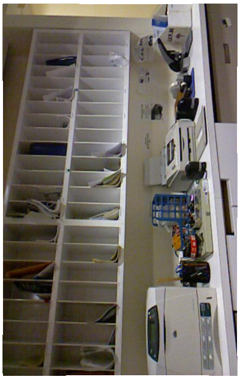

In [42]:
rgb_img0 = images[10]
rgb_img0 = rgb_img0.transpose((1, 2, 0))

print(rgb_img0.shape)

Image.fromarray(np.uint8(rgb_img0)).resize((240, 380))

### Depth Map

(640, 480)


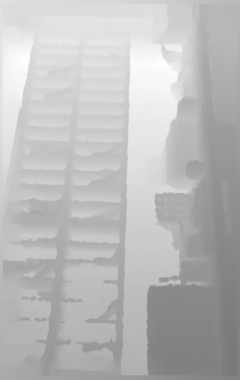

In [43]:
depth_img0 = depths[10]

depth_img0 = depth_img0 / depth_img0.max() * 255

print(depth_img0.shape)

Image.fromarray(np.uint8(depth_img0)).resize((240, 380))

### H5 file

In [53]:
with h5py.File(h5files[0][0], 'r') as h5w:
    rgb_img = np.array(h5w['rgb'])
    depth_img = np.array(h5w['depth'])
type(rgb_img), rgb_img.shape, depth_img.shape

(numpy.ndarray, (3, 480, 640), (480, 640))

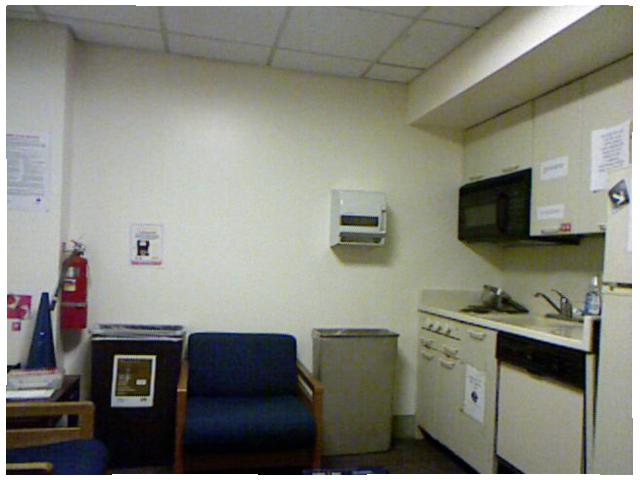

In [54]:
Image.fromarray(rgb_img.transpose((1,2,0)))

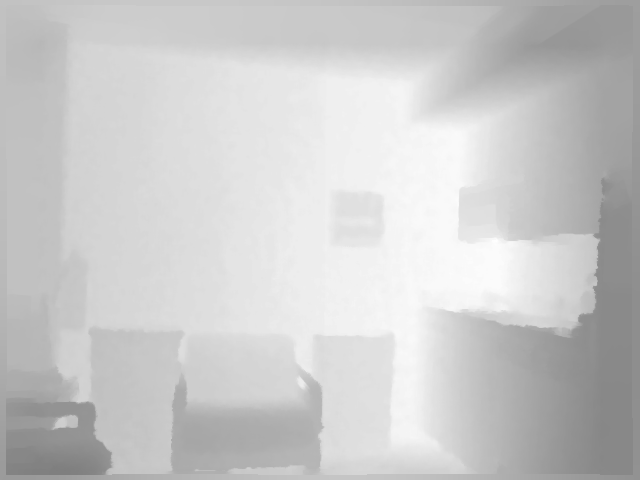

In [58]:
Image.fromarray(depth_img)

In [61]:
np.min(depth_img), np.max(depth_img)

(126, 255)

### Label

In [23]:
labels[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)